In [14]:
"""Collect the Hubbard Brook meteorological data and save to a csv file 
   good for creating forcing NetCDF from.
"""
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import numpy as np
import itertools as it
from sklearn.model_selection import KFold

## 1. Read observations

In [2]:
""" Solar radiation: W m-2
    2014-2019 only
    15 min interval resample to 1 hour"""

solrad = pd.read_csv(os.path.join("../data/Hubbard Brook/knb-lter-hbr.237.1/HBEF_15minSolarRadiation_WX1.csv"))

start_date = pd.Timestamp(year = 2014, month = 7, day = 21, hour = 10, minute = 30)
end_date = pd.Timestamp(year = 2019, month = 4, day = 3, hour = 10, minute = 30)
date_range = pd.date_range(start_date, end_date, freq='15T')

solrad.index = date_range

# average over two stations
solrad = (solrad['SolRad1'] + solrad['SolRad2']) / 2
solrad = solrad.resample('1H').mean()

""" Long term daily precipitation """
precip = pd.read_csv(os.path.join("../data/Hubbard Brook/knb-lter-hbr.14.18/dailyWatershedPrecip1956-2023.csv"), index_col = 0, parse_dates = True)
precip = precip.query('watershed == "W1"')['Precip']


""" 15 minute rain gauge, 2011/8/26-2023
Some values are gap-filled from other stations, which is okay
Summed to mm/hour
"""
precip = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.277.8/HBEF_RG1precipitation_15min.csv",
                     index_col = 1, parse_dates=True)
precip = precip['precip'].resample('1H').sum()

""" 15 minute air temperature, 2015-2023
"""
tair = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.322.4/HBEF_STA1airTemp_15min.csv",
                   index_col = 1, parse_dates=True)
tair = tair['airTemp'].resample('1H').mean()

""" 15 minute relative humidity, 2011-2023 (%)
"""
rh = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.336.2/HBEF_STA1_RH_15min.csv",
                 index_col = 0, parse_dates=True)
rh = rh['STA1_RH'].resample('1H').mean()

""" 15 minutes wind speed, 2014-2023 (m/s)
"""
wind = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.337.3/HBEF_STA1_wind_15min.csv",
                 index_col = 0, parse_dates=True)
wind = wind['WS_ms_Avg'].resample('1H').mean()

<Axes: xlabel='TIMESTAMP'>

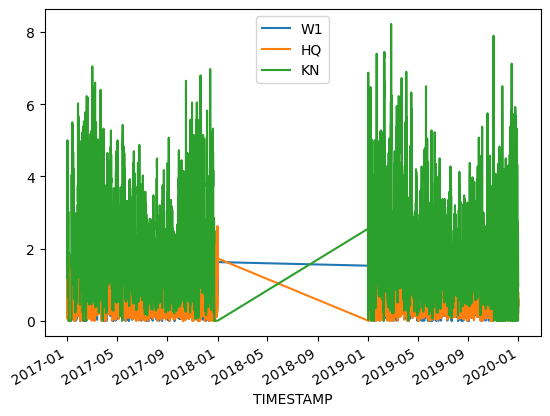

In [3]:
""" Gap-fill wind data from nearby station doesnt work - 
    Turns out they all have the same time period of missing data
"""
########################################
# Read the data
########################################
wind_hq = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.337.3/HBEF_HQ_wind_15min.csv",
                 index_col = 0, parse_dates=True)
wind_hq = wind_hq['WS_ms_Avg'].resample('1H').mean()

wind_kn = pd.read_csv("../data/Hubbard Brook/knb-lter-hbr.337.3/HBEF_Kineo_wind_15min.csv",
                 index_col = 0, parse_dates=True)
wind_kn = wind_kn['WS_ms_Avg'].resample('1H').mean()

wind_combined = pd.concat([wind, wind_hq, wind_kn], axis = 1, join = 'inner')
wind_combined.columns = ['W1', 'HQ', 'KN']
wind_combined = wind_combined.dropna(axis = 0, how = 'any')

wind_combined.loc[wind_combined.index.year.isin([2017, 2019])].plot()

## 2. Read ERA5 and find the time lag

In [4]:
def read_era5(variable):
    filelist = [os.path.join("..","data", "GEE", "HubbardBrook", 
                             f"HubbardBrook_{variable}_{year}.csv") \
                for year in range(2011, 2024)]
    alldata = []
    for file in filelist:
        alldata = alldata + [pd.read_csv(file, index_col = 0, parse_dates=True)[variable]]
    alldata = pd.concat(alldata)
    if variable == "temperature_2m":
        alldata = alldata - 273.15
    if "radiation" in variable:
        alldata = alldata / 3600
    return alldata


tair_era = read_era5("temperature_2m")
solrad_era = read_era5("surface_solar_radiation_downwards_hourly")
wind_era = np.sqrt(read_era5("u_component_of_wind_10m")**2 + \
                   read_era5("v_component_of_wind_10m")**2)
ifrrad_era = read_era5("surface_thermal_radiation_downwards_hourly")
pres_era = read_era5("surface_pressure")

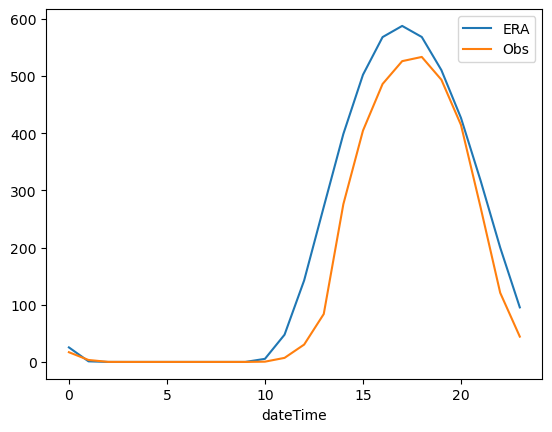

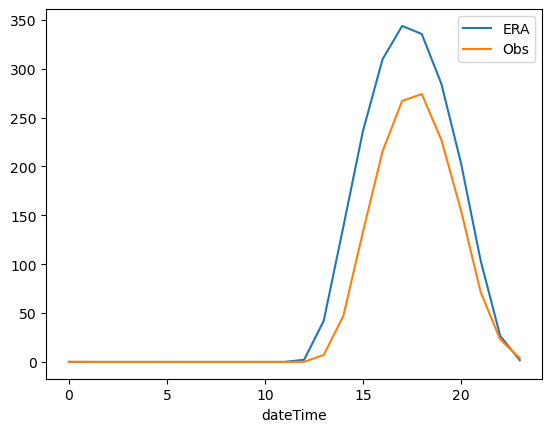

In [5]:
# Check the number of hours shifted
def daylight_savings(tvec):
    dm = tvec.month * 100 + tvec.day
    return (dm >= 310) & (dm <= 1103)

tshift = 6

summer_era = solrad_era.loc[daylight_savings(solrad_era.index)]
summar_obs = solrad.loc[daylight_savings(solrad.index)]

winter_era = solrad_era.loc[~daylight_savings(solrad_era.index)]
winter_obs = solrad.loc[~daylight_savings(solrad.index)]

plt.figure()
summer_era.groupby(summer_era.index.hour).mean().plot(label="ERA")
summar_obs_cycle = summar_obs.groupby(summar_obs.index.hour).mean()
summar_obs_cycle.index = np.mod(summar_obs_cycle.index + tshift, 24)
summar_obs_cycle.sort_index().plot(label = "Obs")
plt.legend()

plt.figure()
winter_era.groupby(winter_era.index.hour).mean().plot(label="ERA")
winter_obs_cycle = winter_obs.groupby(winter_obs.index.hour).mean()
winter_obs_cycle.index = np.mod(winter_obs_cycle.index + tshift, 24)
winter_obs_cycle.sort_index().plot(label="Obs")
plt.legend()

In [116]:
# shift the hour of the observation to UTC
def shift_data(df, hours):
    df = df.copy()
    df.index = df.index + pd.Timedelta(hours = hours)
    return df

solrad_shifted = shift_data(solrad, tshift)
tair_shifted = shift_data(tair, tshift)
rh_shifted = shift_data(rh, tshift)
wind_shifted = shift_data(wind, tshift).dropna()
precip_shifted = shift_data(precip, tshift)

## 3. Perform downscaling for solrad, tair, wind

precip & rh are already 2011-2023, does not need gap-filling

thermal radiation & air pressure can only use ERA5-Land data

In [138]:
def cross_validation(obs, era, log_transform):
    """ Do a scan to identify the most advantageous fit """
    data_combined = pd.concat([obs, era], join = 'inner', axis = 1)
    data_combined.columns = ['obs', 'era']

    if log_transform:
        data_combined = np.log(data_combined + 1)

    doy_list = np.array([ind.dayofyear if (not ind.is_leap_year or \
                                           (ind.month * 100 + ind.day <= 228)) \
                        else (ind.dayofyear-1) for ind in data_combined.index])
    window_list  = [15, 30, 45, 60, 90]

    # use the average RMSE of five-fold cross-validation
    goodness_of_fit = pd.DataFrame(np.nan,
                                   index = pd.MultiIndex.from_product([range(1, 366), range(24)]),
                                   columns = window_list)
    for hour, doy, window in it.product(range(24), range(1, 366), window_list):
        temp = data_combined.loc[(doy_list >= doy - window) & (doy_list <= doy + window), :]
        temp = temp.loc[temp.index.hour == hour]
 
        def _cross_validation(df):
            # five fold cross-validation 
            kf = KFold(n_splits=5)

            error_list = []
            for train_ind, test_ind in kf.split(df):
                train = df.iloc[train_ind]
                test = df.iloc[test_ind]

                # catch zeros for solar radiation
                if train['era'].std() < 1e-6:
                    test_hat = train['obs'].mean()
                else:
                    res = linregress(train['era'], train['obs'])
                    test_hat = test['era']*res.slope + res.intercept
                if log_transform:
                    rmse = np.sqrt(np.mean(np.power(
                        np.exp(test['obs']) - np.exp(test_hat), 2
                    )))
                else:
                    rmse = np.sqrt(np.mean(np.power(test['obs'] - test_hat, 2)))
                error_list.append(rmse)
            return np.mean(error_list)

        goodness_of_fit.loc[(doy, hour), window] = _cross_validation(temp)

    return goodness_of_fit


def downscale_fit(obs, era, best_window, log_transform):
    """ best_window: the best window size based on goodness_of_fit 
                     for each day of year and hour combination
    """
    data_combined = pd.concat([obs, era], join = 'inner', axis = 1)
    data_combined = data_combined.dropna(axis = 0, how = 'any')
    data_combined.columns = ['obs', 'era']

    if log_transform:
        data_combined = np.log(data_combined + 1)

    doy_list = np.array([ind.dayofyear if (not ind.is_leap_year or \
                                           (ind.month * 100 + ind.day <= 228)) \
                        else (ind.dayofyear-1) for ind in data_combined.index])

    # save the equations
    equation_of_fit = pd.DataFrame(np.nan,
                                index = pd.MultiIndex.from_product([range(1, 366), range(24)]),
                                columns = ['slope', 'intercept'])
    for hour, doy in it.product(range(24), range(1, 366)):
        window = best_window.loc[(doy, hour)]

        temp = data_combined.loc[(doy_list >= doy - window) & (doy_list <= doy + window), :]
        temp = temp.loc[temp.index.hour == hour]

        # catch zeros for solar radiation
        if np.std(temp['era']) < 1e-6:
            equation_of_fit.loc[(doy, hour), 'slope'] = 0.
            equation_of_fit.loc[(doy, hour), 'intercept'] = temp['obs'].mean()
        else:
            res = linregress(temp['era'], temp['obs'])
            equation_of_fit.loc[(doy, hour), 'slope'] = res.slope
            equation_of_fit.loc[(doy, hour), 'intercept'] = res.intercept

    return equation_of_fit


def downscaling_apply(index_to_predict, era, equation_of_fit, log_transform):
    if len(era.index.intersection(index_to_predict)) != len(index_to_predict):
        raise Exception('ERA range is not sufficient. Reduce gap-filling range.')

    doy_list = np.array([
        ind.dayofyear if (not ind.is_leap_year or (ind.month * 100 + ind.day <= 228)) \
        else (ind.dayofyear-1) for ind in index_to_predict
    ])

    slope_list = np.array([
        equation_of_fit.loc[(doy_list[i], ind.hour), 'slope'] \
        for i, ind in enumerate(index_to_predict)
    ])

    intercept_list = np.array([
        equation_of_fit.loc[(doy_list[i], ind.hour), 'intercept'] \
        for i, ind in enumerate(index_to_predict)
    ])

    if log_transform:
        pred = np.log(era.loc[index_to_predict] + 1)
    else:
        pred = era.loc[index_to_predict]
    era_pred = pred * slope_list + intercept_list
    if log_transform:
        era_pred = np.exp(era_pred) - 1

    return era_pred

In [139]:
# Prepare the metdata array
metdata_all = pd.concat([precip_shifted, rh_shifted, ifrrad_era, pres_era], 
                        axis = 1, join = 'inner')
metdata_all.columns = ['Precip (mm/hour)', 'RH (%)', 'RLDS (W/m2)', 'Pressure (Pa)']
metdata_all

,Precip (mm/hour),RH (%),RLDS (W/m2),Pressure (Pa)
2011-10-12 19:00:00,0.0,61.666667,313.682500,95467.335938
2011-10-12 20:00:00,0.0,63.250000,312.300278,95472.902344
2011-10-12 21:00:00,0.0,68.250000,321.391944,95440.613281
2011-10-12 22:00:00,0.0,72.500000,336.695833,95449.750000
2011-10-12 23:00:00,0.0,77.250000,343.076667,95472.222656
...,...,...,...,...
2023-05-16 01:00:00,0.0,41.747500,284.769983,94505.058594
2023-05-16 02:00:00,0.0,36.230000,284.226892,94476.531250
2023-05-16 03:00:00,0.0,33.592500,289.504253,94411.304688
2023-05-16 04:00:00,0.0,34.995000,287.604601,94357.312500


In [140]:
# Check to make sure no missing days after join
tdiff = (metdata_all.index[-1] - metdata_all.index[0])
print(tdiff.total_seconds() / 3600)

101602.0


In [141]:
# Takes forever to run. Therefore save the outcomes
best_window = {}
for name, obs, era in [
    ('Wind', wind_shifted, wind_era),
    ('Tair', tair_shifted, tair_era),
    ('RSDS', solrad_shifted, solrad_era)
]:
    #############################################
    # 1. Find the best window to do regression
    #############################################

    # Because wind's distribution is a little skewed, use log transform
    if name == 'Wind':
        log_transform = True
    else:
        log_transform = False

    goodness_of_fit = cross_validation(obs, era, log_transform)
    goodness_of_fit.unstack().median(axis = 0).unstack().T.plot()
    plt.title(name)
    plt.ylabel('RMSE of five-fold cross-validation')
    plt.savefig(f'./temp/downscaling_fit_{name}.png')

    best_window[name] = goodness_of_fit.apply(lambda ds: ds.index[ds.argmin()], axis = 1)

    #############################################
    # 2. Use the best window to do regression
    #############################################
    equation_of_fit = downscale_fit(obs, era, best_window[name], log_transform)
    equation_of_fit.to_csv(f'./temp/downscaling_equation_{name}.csv')

    #############################################
    # 3. Use the regression equation to estimate downscaled values
    #############################################
    missing_values = metdata_all.index.difference(obs.index)
    obs_pred = downscaling_apply(missing_values, era, equation_of_fit, log_transform)
    metdata_all[name] = pd.concat([obs_pred, obs]).sort_index()

    if name == 'RSDS' or name == 'Wind':
        metdata_all[name] = metdata_all[name].clip(lower = 0.)

    metdata_all[name].to_frame(name).to_csv(f'./temp/downscaling_result_{name}.csv')

best_window = pd.DataFrame(best_window)
best_window.index.names = ['dayofyear','hourofday']
best_window.to_csv(f'./temp/downscaling_best_window.csv')

metdata_all.to_csv(f'./temp/downscaling_result.csv')

<Axes: >

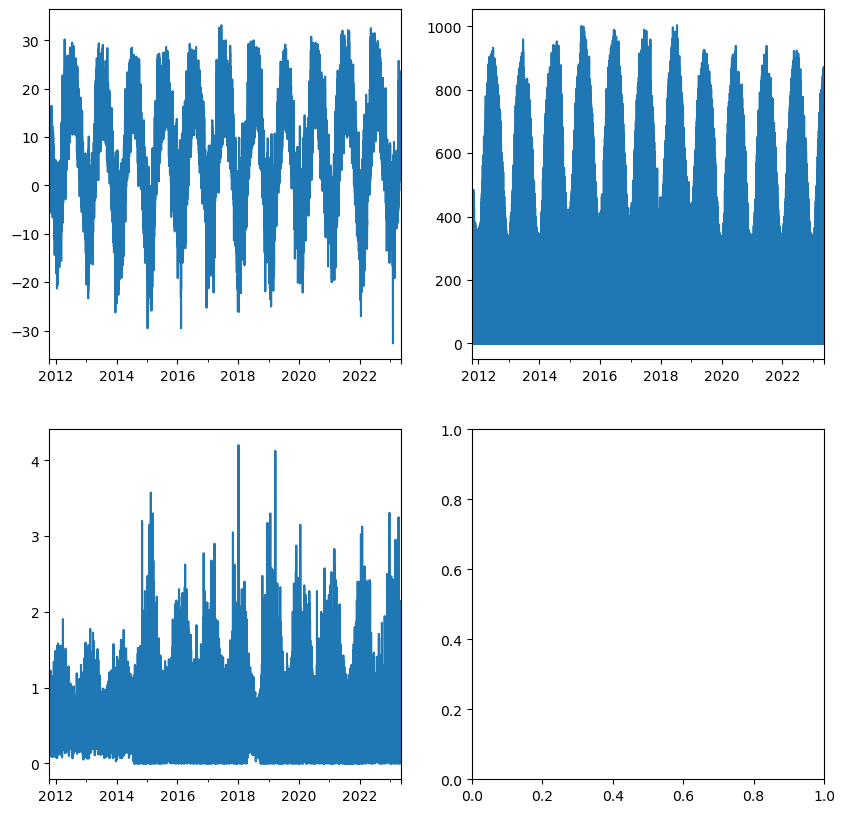

In [ ]:
# Check the gap-filled diurnal cycle and daily statistics
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
metdata_all['Tair'].plot(ax = axes.flat[0])
metdata_all['RSDS'].plot(ax = axes.flat[1])
metdata_all['Wind'].plot(ax = axes.flat[2])

C:\Users\ywo\AppData\Local\Temp\ipykernel_14340\2068137161.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (t[0] > 0):


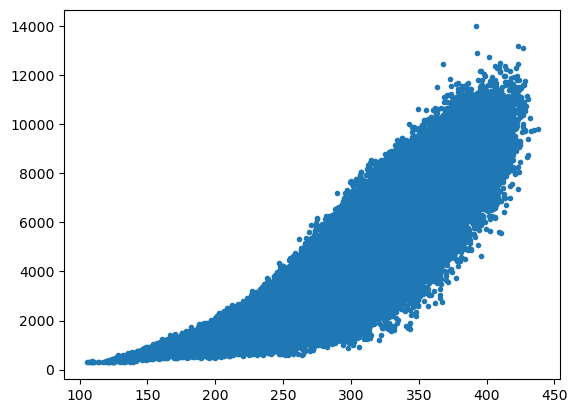

In [79]:
# Check the ERA longwave radiation against what is calculated from T and RH
# The ERA ones clearly make much more sense

def esat(t):
    #coefficients for calculating saturation vapor pressure
    a = [6.107799961, 4.436518521e-01, 1.428945805e-02, 2.650648471e-04, \
            3.031240396e-06, 2.034080948e-08, 6.136820929e-11]
    b = [6.109177956, 5.034698970e-01, 1.886013408e-02, 4.176223716e-04, \
            5.824720280e-06, 4.838803174e-08, 1.838826904e-10]
    if (t[0] > 0):
        myesat = (a[0]+t*(a[1]+t*(a[2]+t*(a[3]+t*(a[4]+t*(a[5]+t*a[6]))))))
    else:
        myesat = (b[0]+t*(b[1]+t*(b[2]+t*(b[3]+t*(b[4]+t*(b[5]+t*b[6]))))))
    myesat = myesat * 100. # convert from hPa to Pa
    return myesat


stebol = 5.67e-8
mye = esat(metdata_all['Tair']) * metdata_all['RH (%)'] / 100
ea = 0.70 + 5.95e-5*mye*np.exp(1500.0/(metdata_all['Tair'] + 273.15))
flds = ea * stebol * (metdata_all['Tair'] + 273.15) ** 4

plt.plot(metdata_all['RLDS (W/m2)'], flds, '.')